# Visualizing the Corpus of ACL 2017 Paper Titles

There was a significant variation topics covered in long and short papers in ACL 2017.  Below is an application of Scattertext, written up in an ACL 2017 demo paper, on visualizing the differences in these paper titles.

Jason S. Kessler. Scattertext: a Browser-Based Tool for Visualizing how Corpora Differ. To appear in ACL Demos. Vancouver, BC. 2017.

https://github.com/JasonKessler/scattertext

https://arxiv.org/abs/1703.00565

## Let's first, parse the accepted papers blog post using Beautiful Soup and load it into a Pandas data frame

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import pygal
import scattertext as st
from IPython.display import IFrame
from IPython.core.display import display, HTML
import seaborn as sns
display(HTML("<style>.container { width:98% !important; }</style>"))
%matplotlib inline

In [2]:
url = 'https://chairs-blog.acl2017.org/2017/04/05/accepted-papers-and-demonstrations/'
soup = BeautifulSoup(requests.get(url).text, 'lxml')
content = soup.find_all('div', class_='entry-content')[0]

def split_authors(author_list):
    return re.split('(?:\W+and|\,)\W+', author_list)

assert split_authors('Sayan Ghosh, Mathieu Chollet, Eugene Laksana, Stefan Scherer and Louis-Philippe Morency') \
    == ['Sayan Ghosh', 'Mathieu Chollet', 'Eugene Laksana', 'Stefan Scherer', 'Louis-Philippe Morency']
assert split_authors('Sayan Ghosh, Mathieu Chollet, Eugene Laksana, Stefan Scherer, and Louis-Philippe Morency') \
    == ['Sayan Ghosh', 'Mathieu Chollet', 'Eugene Laksana', 'Stefan Scherer', 'Louis-Philippe Morency']
    
data = []
for paper_length in content.find_all('h2'):
    length_name = paper_length.text.strip()
    field = 'N/A'
    for sib in paper_length.findNextSiblings():
        if sib.name == 'h2':
            break
        if sib.name == 'h3':
            field = sib.text.strip()
        if sib.name == 'ol':
            for paper in sib.find_all('li'):
                try:
                    title, authors = paper.text.split('Authors:')
                except:
                    continue
                data.append({'Paper Type': length_name,
                             'Field': field,
                             'Title': title.strip(),
                             'Authors': split_authors(authors.strip())})
df = pd.DataFrame(data)
df['author count'] = df.Authors.apply(len)    
df['Paper Type']= df['Paper Type'].apply(lambda x: {'Accepted Long Papers':'Long', 
                                  'Accepted Short Papers':'Short',
                                  'Accepted Software Demonstrations':'Demo',
                                  'Transactions of the ACL articles to be presented at ACL 2017':'TACL'}[x])

In [3]:
df['Paper Type'].unique()

array(['Long', 'Short', 'Demo', 'TACL'], dtype=object)

## Let's use Scattertext to see how the titles of long and short papers differ
End-to-end modeling, joint modeling, adversarial learning, and reading comprehension were particularly characteristic of long papers. 

Case studies, social media, multilingual analysis and were more prevalent in short papers. The term "temporal" fell victim to polysemy-- both temporal relation mining and trend-over-time analysis were common in short papers.

Learning, neural, and translation were very common in both sets. 

Click around on the plot below to see other findings.

In [4]:
df['Parsed'] = df['Title'].apply(st.whitespace_nlp)
long_short_df = df[df['Paper Type'].isin(['Long', 'Short'])]
long_short_corpus = (st.CorpusFromParsedDocuments(long_short_df, 
                                                  category_col = 'Paper Type', 
                                                  parsed_col = 'Parsed', 
                                                  feats_from_spacy_doc = st.FeatsFromSpacyDoc(strip_final_period=True))
                     .build()
                     .get_stoplisted_unigram_corpus())
html = st.produce_scattertext_explorer(long_short_corpus, 
                                       category='Long', 
                                       category_name='Long Papers', 
                                       not_category_name='Short Papers',
                                       minimum_term_frequency=1,
                                       metadata=long_short_df.apply(lambda x: ', '.join(x['Authors']) + '('+x['Field']+')', axis=1),
                                       use_full_doc=True,
                                       width_in_pixels=1000)
file_name = "ACL2017LongShort.html"
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1200, height=1000)

In [21]:
from scattertext.termsignificance import LogOddsRatioUninformativeDirichletPrior
term_freq_df = long_short_corpus.get_term_freq_df()
frequencies = term_freq_df.sum(axis=1).values
frequencies_scaled = frequences/frequences.max()
p_vals = LogOddsRatioUninformativeDirichletPrior().get_p_vals(term_freq_df.values)


## As requested by Min-Yen Kan, let's look at how TACL differs from long papers

Interesting finding: no TACL paper uses the word "networks" in its title, but lots of long papers do. 

Two TACL papers talked about "effects", while no long papers did:
- "evaluating visual representations for topic understanding and their effects on manually generated labels"
- "winning on the merits: the joint effects of content and style on debate outcomes"

"LSTMs" appears to be a false positive for TACL, since the unmarked "LSTM" appeared four times in long papers.  (I'm safely assuming the long papers used multiple LSTM nodes.)

In [5]:
df['Parsed'] = df['Title'].apply(st.whitespace_nlp)
long_short_df = df[df['Paper Type'].isin(['Long', 'TACL'])]
long_short_corpus = (st.CorpusFromParsedDocuments(long_short_df, 
                                                  category_col = 'Paper Type', 
                                                  parsed_col = 'Parsed', 
                                                  feats_from_spacy_doc = st.FeatsFromSpacyDoc(strip_final_period=True))
                     .build()
                     .get_stoplisted_unigram_corpus())
def get_metadata(x):
    meta = ', '.join(x['Authors']) 
    if x['Field'].strip():
        meta += ' ('+x['Field']+')'
    return meta
    
html = st.produce_scattertext_explorer(long_short_corpus, 
                                       category='TACL', 
                                       category_name='TACL Papers', 
                                       not_category_name='Long Papers',
                                       minimum_term_frequency=1,
                                       metadata=long_short_df.apply(get_metadata, axis=1),
                                       use_full_doc=True,
                                       width_in_pixels=1000)
file_name = "ACL2017TACLLong.html"
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1200, height=1000)

## Let's see how the papers the area chairs published differed from the rest of the set

The 53 papers were co-authored by an area chair, and 290 were only authored by average joes. 

"Fast and accurate" was a phrase used by two area chairs and nobody else.

Lots of people worked on Chinese, but no area chairs had "Chinese" in their paper titles.   "Dialog" and "adpatation" were strongly associated with average joes. 

In [6]:
import itertools
area_chairs = set(itertools.chain(*[x.split(':')[1].strip().split(', ') for x in '''Biomedical: Aurélie Névéol, Karin Verspoor
Cognitive Modeling and Psycholinguistics: Roger Levy, Anders Søgaard
Dialogue and Interactive Systems: Ron Artstein, Raquel Fernandez, Oliver Lemon
Discourse and Pragmatics: Yangfeng Ji, Sujian Li, Bonnie Webber
Information Extraction and NLP Applications: Eugene Agichtein, Chia-Hui Chang, Jing Jiang, Sarvnaz Karimi, Zornitsa Kozareva, Kang Liu, Tie-Yan Liu, Mausam, Alessandro Moschitti, Smaranda Muresan
Machine Learning: Grzegorz Chrupała, Amir Globerson, Tommi Jaakkola, Sujith Ravi, William Yang Wang
Machine Translation: Yang Liu, Minh-Thang Luong, Haitao Mi, Graham Neubig, Deyi Xiong
Multidisciplinary: Michael Piotrowski, Karën Fort
Multilinguality: Omri Abend, Mona Diab
Phonology, Morphology and Word Segmentation: Jason Eisner, Hinrich Schütze
Resources and Evaluation: Sophie Rosset, Wajdi Zaghouani
Semantics: Manaal Faruqui, Hannaneh Hajishirzi, Anna Korhonen, Preslav Nakov, Mehroosh Sadrzadeh, Aline Villavicencio
Sentiment Analysis and Opinion Mining: Alexandra Balahur, Lun-Wei Ku, Saif M Mohammad
Social Media: Zhiyuan Liu, Shimei Pan, Svitlana Volkova
Speech: Chiori Hori, Chia-ying Lee
Summarization and Generation: Wenjie Li, Alexander M Rush, Verena Rieser
Tagging, Chunking, Syntax and Parsing: Emily Pitler, Barbara Plank, Yue Zhang, Hai Zhao
Vision, Robotics and Grounding: Mohit Bansal, Nate Kushman'''.split('\n')]))
df['AC'] = df.Authors.apply(lambda x: 'Area Chair' if set(x) & area_chairs != set() else 'Average Joe')
df['AC'].value_counts()

Average Joe    291
Area Chair      53
Name: AC, dtype: int64

In [7]:
area_chair_corpus = (st.CorpusFromParsedDocuments(df, 
                                                  category_col = 'AC', 
                                                  parsed_col = 'Parsed', 
                                                  feats_from_spacy_doc = st.FeatsFromSpacyDoc(strip_final_period=True))
                     .build()
                     .get_stoplisted_unigram_corpus())
def get_metadata(x):
    meta = ', '.join(x['Authors']) 
    meta += '('+x['Paper Type']+'; '+x['Field']+')'
    return meta
    
html = st.produce_scattertext_explorer(area_chair_corpus, 
                                       category='Area Chair', 
                                       category_name='Area Chair', 
                                       not_category_name='Average Joe',
                                       minimum_term_frequency=1,
                                       metadata=df.apply(get_metadata, axis=1),
                                       use_full_doc=True,
                                       width_in_pixels=1000)
file_name = "ACL2017AC.html"
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1200, height=1000)

## Let's look at some descriptive statistics about the set accepted papers, and look at variations in paper categories
The vast majority of papers are long papers. MT, Semantics, and Gen. Summarization were more associated with Long Papers, while ML, Social Media, and Multidisciplinary dominated short papers. 

In [224]:
HTML(pygal.HorizontalStackedBar(explicit_size=5, 
                                height=100,
                                x_labels = list(df['Paper Type'].value_counts().index),
                                style=pygal.style.DefaultStyle(value_font_size=10), print_values=True)
     .add('Paper Type', df['Paper Type'].value_counts())
     .render(is_unicode=True))

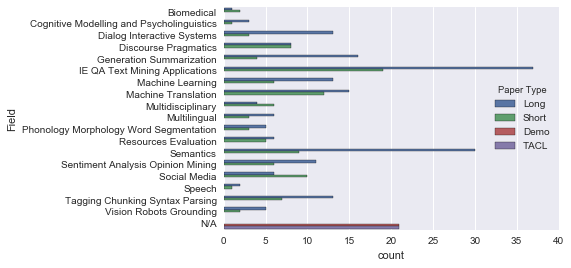

In [225]:
pct_df['Field %'] = pct_df['Title_x']/pct_df['Title_y']
type_field_df = df.groupby(['Paper Type', 'Field'])['Title'].count().reset_index()
type_field_df.columns = ['Count' if c == 'Title' else c for c in type_field_df.columns]
_=sns.countplot(data=df, y='Field', hue='Paper Type')

In [227]:
long_short_type_field_df = (type_field_df[type_field_df['Paper Type'].isin(('Long', 'Short'))]
                            .pivot(index='Field',columns='Paper Type')['Count'].fillna(0).astype(int))

data = [{'value': tuple(vals), 'label': lab} for vals, lab in zip(long_short_type_field_df.values, long_short_type_field_df.index)]
chart = (pygal
     .XY(print_labels=True, print_values=True, stroke=False, legend_at_bottom=True, x_title='Long Papers', y_title="Short Papers",
         style=pygal.style.DefaultStyle(value_font_size=10, label_font_size=10,legend_font_size=10, value_label_font_size=10, major_label_font_size=10), explicit_size=10))

for vals, lab in zip(long_short_type_field_df.values, long_short_type_field_df.index):
    chart.add(lab, [{'value':vals,'label':lab[:20]}])
HTML(chart.render(is_unicode=True))